# MADE予測テスト

## import

In [11]:
import numpy as np
import scipy
import torch
import matplotlib.pyplot as plt
import pickle
import pathlib

import ising_model as ising
import made
import mcmc_function as mcmc
import QAOA_function as qaoa

seed = 1514
rng = np.random.default_rng(seed)

## インスタンス設定

In [12]:
"""
n_spin = 6
instance = ising.Ising_model(n_spin, type='SK')
"""
n_spin = 5
source_dir_name = 'data'
fname_in = pathlib.Path(source_dir_name).joinpath('{0}_sites_instance.pickle'.format(n_spin))
with open(str(fname_in), 'rb') as f:
	instance = pickle.load(f)
 
beta = 1.0

## 予測とモデル分布の比較

### 学習

Optimization terminated successfully.
         Current function value: -2.650621
         Iterations: 24
         Function evaluations: 341
         Gradient evaluations: 31


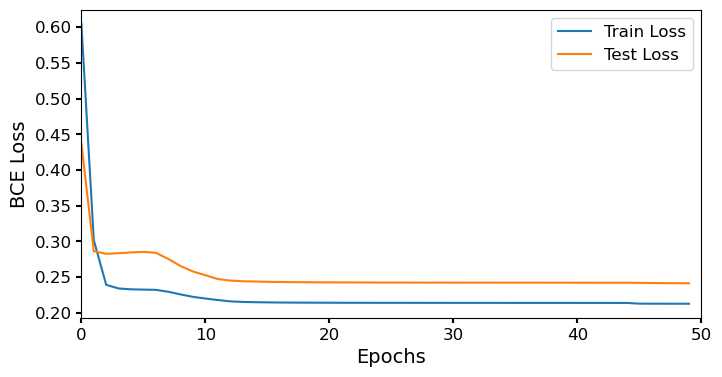

In [13]:
# setting
prob_hamiltonian = instance.get_hamiltonian()
mixer_hamiltonian = qaoa.generate_X_mixer(n_spin)
n_layers = 5
qaoa_ansatz = qaoa.QAOA_ansatz(prob_hamiltonian, mixer_hamiltonian, n_layers)

def cost(para):
    return qaoa.cost_QAOA(prob_hamiltonian, qaoa_ansatz, para)

def callback(para):
    para_history.append(para)
    cost_history.append(cost(para))

# running QAOA
#init_para = [rng.uniform(0, 2*np.pi) for i in range(2*n_layers)]
init_para = [0.2705, -0.5899, 0.4803, -0.4492, 0.5074, -0.3559, 0.5646, -0.2643, 0.6397, -0.1291] #文献におけるSKmodelに対するQAOA(p=5)の固定角
para_history = [init_para]
cost_history = [cost(init_para)]

method = "BFGS"
options = {"disp": True, "maxiter": 200, "gtol": 1e-6}
opt = scipy.optimize.minimize(cost, init_para, 
                              method=method,
                              callback=callback,
                              options=options)

opt_para = para_history[-1]

# sampling QAOA outputs
n_data = 1200
n_train = int(0.8*n_data)

opt_qaoa_data_idx = qaoa.sampling_QAOA(qaoa_ansatz, para_history[-1], n_data) # optimize parameter
opt_qaoa_data_nd = np.array([qaoa.number_to_binary(opt_qaoa_data_idx[i], n_spin) for i in range(n_data)], dtype='float32') # MADEモデルのコードが重み行列をfloat32で記述しているため、データもfloat32に明示的に指定する！

traindata, testdata = torch.utils.data.random_split(dataset=opt_qaoa_data_nd, lengths=[n_train, n_data-n_train])
trainset = torch.utils.data.DataLoader(traindata, batch_size=8, shuffle=False)
testset = torch.utils.data.DataLoader(testdata, batch_size=8, shuffle=True)

hidden_layers = 2
hidden_size = 2*n_spin
hidden_list = [hidden_size for i in range(hidden_layers)]
model = made.MADE(n_spin, hidden_list, n_spin, num_masks=1, natural_ordering=True)
opt = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=45, gamma=0.1)

n_epochs = 50
train_loss, test_loss = made.run_train(model, trainset, testset, n_epochs, opt, scheduler, seed)

fig1, ax1 = plt.subplots(figsize=(8,4), dpi=100)
ax1.plot(np.arange(n_epochs), train_loss, label='Train Loss')
ax1.plot(np.arange(n_epochs), test_loss, label='Test Loss')
ax1.set_xlabel("Epochs", fontsize=14)
ax1.set_ylabel("BCE Loss", fontsize=14)
ax1.tick_params(width=1.5, labelsize=12)
ax1.set_xlim(0, n_epochs)
ax1.legend(fontsize=12)

### サンプリング

(1200, 5)
[4.7771445e-01 4.3763331e-01 3.2328308e-02 2.8404849e-02 3.8512938e-03
 4.1979426e-03 2.6483389e-03 4.9173465e-04 6.2358775e-04 2.5263266e-04
 2.2811850e-03 2.8142304e-04 1.4840584e-03 5.7768408e-04 2.5353667e-03
 1.8240388e-03 7.9157515e-05 9.3557828e-05 4.8536192e-05 8.2950079e-04
 1.8106855e-05 4.9919257e-05 1.7174342e-04 1.1847059e-04 1.0082242e-03
 3.4799776e-04 2.2204689e-05 6.2057778e-05 3.9617994e-06 1.5413601e-05
 8.4226338e-07 1.7533453e-07]


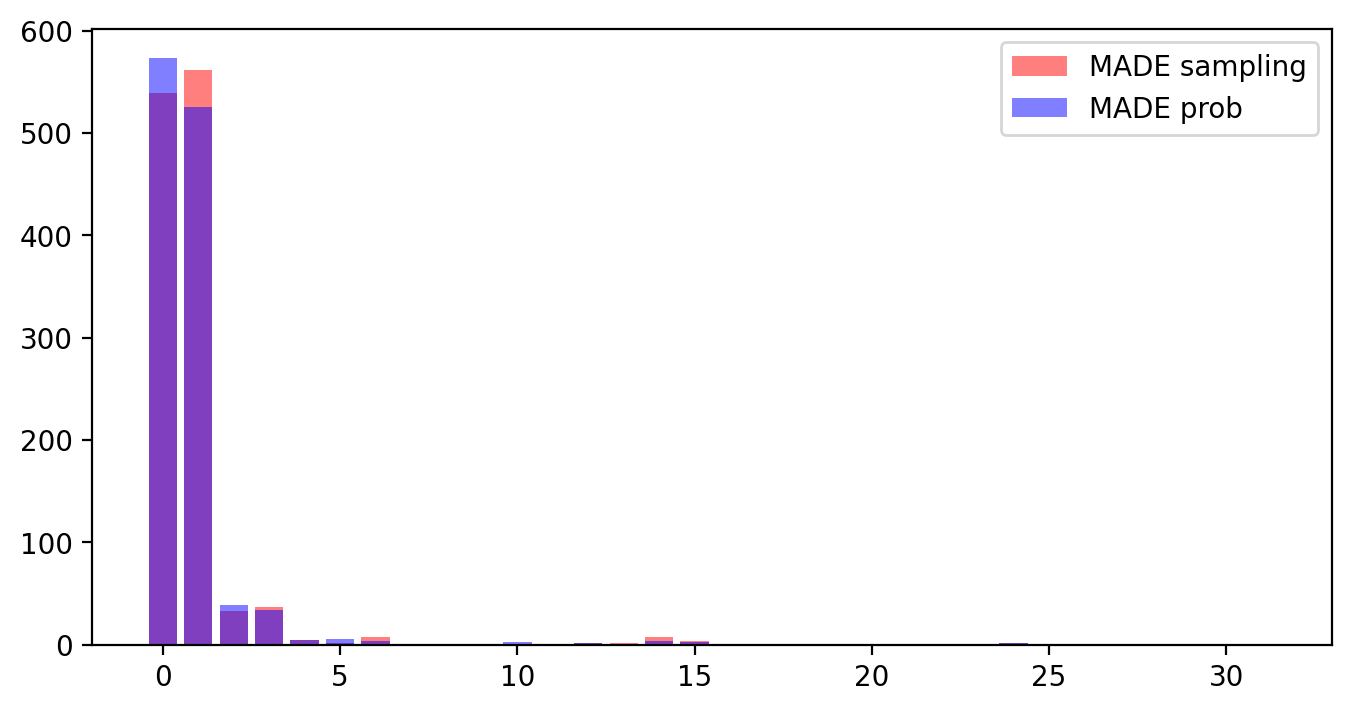

In [18]:
# predict the model
#inputs_nd = rng.integers(2, size=(n_data, n_spin)).astype(np.float32)
inputs_nd = opt_qaoa_data_nd
#qaoa_pred_data_nd = made.predict(model, inputs_nd)
qaoa_pred_data_nd = made.predict(model, n_data)
print(qaoa_pred_data_nd.shape)
qaoa_pred_data_idx = np.array([made.binary_to_number(qaoa_pred_data_nd[i]) for i in range(qaoa_pred_data_nd.shape[0])])
qaoa_pred_data_hist = np.histogram(qaoa_pred_data_idx, bins=np.arange(2**n_spin+1))

# the output distribution of the model
all_inputs = np.array([made.number_to_binary(i, n_spin) for i in range(2**n_spin)])
pred_prob = made.compute_log_prob(model, all_inputs)
pred_prob = np.exp(pred_prob) * n_data

# energy sort
min_energy = ising.min_exact_spin_energy(instance)
boltzmann_prob = ising.spin_boltzmann_distribution(instance, beta)
boltzmann_prob_sort = np.sort(boltzmann_prob)[::-1]

# plot
n_top = 2**n_spin
sort_idx = np.argsort(boltzmann_prob)[::-1]
fig3_3, ax3_3 = plt.subplots(figsize=(8,4), dpi=200)
ax3_3.bar(np.arange(n_top), qaoa_pred_data_hist[0][sort_idx[0:n_top]], color='red', alpha=0.5, label='MADE sampling')
ax3_3.bar(np.arange(n_top), pred_prob[sort_idx[0:n_top]], color='blue', alpha=0.5, label='MADE prob')
#ax3_3.bar(np.arange(n_top), boltzmann_prob_sort[0:n_top]*n_data, color='green', alpha=0.5, label='Boltzmann prob')
#ax3_3.bar(np.arange(2**n_spin), qaoa_pred_data_hist[0], color='red', alpha=0.5, label='MADE sampling')
#ax3_3.bar(np.arange(2**n_spin), pred_prob, color='blue', alpha=0.5, label='MADE prob')
ax3_3.legend()

print(pred_prob[sort_idx[0:n_top]] / n_data)